# Sentence Piece

아마 여러분들은 네이버 영화리뷰 감정분석 태스크를 한 번쯤은 다루어 보았을 것입니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.

만약 이 문제에서 tokenizer를 sentencepiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.

    네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

    학습된 모델로 sp_tokenize() 메소드 구현하기

    구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

    KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

    (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

    Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

    머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.


# 데이터 불러오기

In [76]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import konlpy
import os
import tensorflow as tf

# 데이터를 읽어봅시다. 
train_file = os.getenv('HOME') + '/aiffel/sentencepiece/ratings_train.txt'
test_file =  os.getenv('HOME') + '/aiffel/sentencepiece/ratings_test.txt'
train_data = pd.read_csv(train_file, sep = '\t', quoting = 3)
test_data = pd.read_csv(test_file, sep = '\t', quoting = 3)
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


## 결측치 확인 및 제거

In [77]:
train_data = train_data.dropna()
train_data = train_data['document']

In [78]:
test_data = test_data.dropna()
test_data = test_data['document']

In [79]:
print(train_data.shape)
print(test_data.shape)

(149995,)
(49997,)


## 데이터 살펴보기

문장의 최단 길이: 1
문장의 최장 길이: 158
문장의 평균 길이: 35


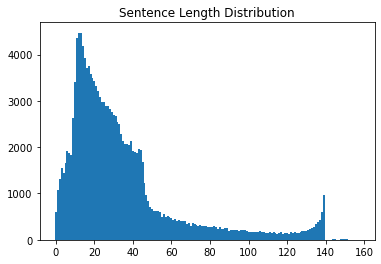

In [80]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [81]:
def check_sentence_with_length(train_data, length):
    count = 0
    
    for sen in train_data:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(train_data, 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳
ㅋ
네
ㅎ
ㅋ
굿
ㅇ
k
.
굿
굿
굳
ㅠ
?
1
ㅋ
굿
쒯
굿
굿
굳
♬
굿
토
ㅋ
ㅋ
굿
ㅋ
굿
O
똥
ㅎ
.
굿
ㅎ
짱
굳
굿
굿
짱
?
z
굿
짱
음
굳
ㅇ
헐
굳
굳
굿
굿
굿
삼
꽝
굿
굿
굿
굿
ㅎ
굳
굿
4
!
?
ㅎ
1
굳
.
ㅎ
풉
아
굿
똥
ㅅ
왜
ㄴ
굳
쉣
봐
z


In [82]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 4
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46


In [83]:
check_sentence_with_length(train_data, 11)

백봉기 언제나오나요?
아주 모자라진 않다.
공유 존잘!!!ㅎㅎㅎ
4대2라니....최악
내 생의 최고의 영화
이딴게 한국 영화라니
번지수 잃고 갈팡질팡
너무나 감동적인 영화
내 인생 최고의 영화
참 재밌는 영화 ㅎㅎ
2.2고고하자 ㅋㅋㅋ
난 별로던데 -_ -
커스틴 때문에 좋겠다
재미있게봄 감동적이고
딱 90년대코미디영화
이건좀 아니잖아...
최고의 드라마....
야경꾼보다 엉망지루함
딱말해준다잉 안나온다
장선우 여전히 쓰레기
한국영화흥행의 시작점
이런게 영화라는거죠.
억지...억지....
세련되고 재밌었어요.
시대착오적 애니메이션
이건 또 뭔가요;;;
망작 중의 망작...
노답이다 진짜....
무의미한 애니메이션.
거 참 재밌는 영화균
상영관좀 늘려주세요.
픽션이지만 재미뚬ㅎㅎ
한지민은 여신이다..
또 번개냐 ㅋㅋㅋㅋㅋ
뷰우우우우티이이이이풀
막장드라됨급도 안됨.
2탄에 비하면 뭐..
개꿀잼ㅋ개꿀잼ㅋ10자
재밌어요 나름 괜찮음
너무 감동적이에욧><
그지같다고!!!!!!
별로에요 재미없네요호
짜리몽땅 파이팅!!!
구관이 명관이다...
진짜볼만함!!@!@!
하 시방ㅡㅡ:@!?.
이제보니까 장백기였네
쓰레기..10자 채움
하나님살려주시지...
대략 재미 없음...
굿굿 잘봤습니다~~ㅅ
나도 다큐나 찍어볼까
마지막에어이없네왜죽어
아바타같은소리하네..
이건 정말 명작이네요
별덤높이기다디다디도러
재밌다........
쓰레기다 솔직히...
정말 현실성없는 영화
재밌게 잘봣습니다!!
어린아이들만 재미있고
그렇게 대단하지 않다
로코좋아하는분께추천!
린제리 로한 사랑함.
내용을말로표현못하게씀
잼있습니다 야호호호호
정말 훈훈한방송입니다
박준형?이 나온다;;
병만옹 짱짜아악앙맨앤
재미있네요.훌륭합니다
정말 소름끼친다!!!
오겡끼데쓰까 부시맨!
좋다.,/,./,./
말할것도없다 최고ㅇㅇ
일하기싫었나봐여ㅎㅅㅎ
인생을 느끼다....
기억이 가물가물하네요
꿀잼 다시보고싶은영화
표절?표절?표절?표절
이거 우리나라꺼 아님
개연성은 개나 줘버려
엉망진창 로맨틱드라마
가슴이 바운OO운스~
노잼 ㅡ

Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 158
문장의 평균 길이: 36


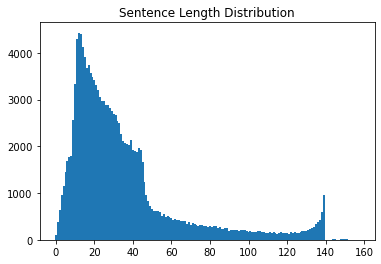

In [84]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(train_data))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

Data Size: 135206


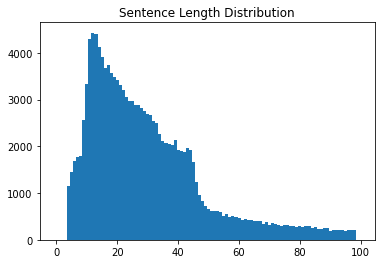

In [85]:
max_len = 100
min_len = 5

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

print("Data Size:", len(filtered_corpus))
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## Sentence Piece 학습

In [86]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-rw-r-- 1 aiffel-dj53 aiffel-dj53 375254  4월 17 01:12 korean_spm.model
-rw-rw-r-- 1 aiffel-dj53 aiffel-dj53 144704  4월 17 01:12 korean_spm.vocab


In [87]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1525, 10, 406, 15, 1391, 10, 140, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [88]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [91]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)

In [94]:
print(tensor)

[[ 144 2018  868 ...    0    0    0]
 [  54   12 4206 ...    0    0    0]
 [  58  842 6006 ...    0    0    0]
 ...
 [ 218   88   28 ...    0    0    0]
 [6295 2508    7 ...    0    0    0]
 [1793 1712  162 ...    0    0    0]]


### ㄴ 정수화된 tensor값들이 나열됐다.

In [97]:
print(s.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(s.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[32, 97, 609, 92]
